<a href="https://colab.research.google.com/github/srishtisri0118/Thesis_Srishti_Sri_Srivastava/blob/main/walmart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# 1. Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, classification_report


In [4]:
# 2. Load Dataset
df = pd.read_csv('/content/drive/MyDrive/MY_THESIS_SUBMISSION/walmart_jan.csv')
print("Dataset Loaded Successfully!")
print(df.head())

Dataset Loaded Successfully!
   User_ID Product_ID Gender   Age  Occupation City_Category  \
0  1000001  P00069042      F  0-17          10             A   
1  1000001  P00248942      F  0-17          10             A   
2  1000001  P00087842      F  0-17          10             A   
3  1000001  P00085442      F  0-17          10             A   
4  1000002  P00285442      M   55+          16             C   

  Stay_In_Current_City_Years  Marital_Status  Product_Category  Purchase  
0                          2               0                 3      8370  
1                          2               0                 1     15200  
2                          2               0                12      1422  
3                          2               0                12      1057  
4                         4+               0                 8      7969  


In [5]:
# 3. Basic Information
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   User_ID                     550068 non-null  int64 
 1   Product_ID                  550068 non-null  object
 2   Gender                      550068 non-null  object
 3   Age                         550068 non-null  object
 4   Occupation                  550068 non-null  int64 
 5   City_Category               550068 non-null  object
 6   Stay_In_Current_City_Years  550068 non-null  object
 7   Marital_Status              550068 non-null  int64 
 8   Product_Category            550068 non-null  int64 
 9   Purchase                    550068 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 42.0+ MB
None
            User_ID     Occupation  Marital_Status  Product_Category  \
count  5.500680e+05  550068.000000   550068.000000     550068.000000   
mean 

In [6]:
# Handling Missing Values
print("Missing values in each column:")
print(df.isnull().sum())

Missing values in each column:
User_ID                       0
Product_ID                    0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category              0
Purchase                      0
dtype: int64


In [7]:
# before dropping duplicates
print(f"Dataset shape before removing duplicates: {df.shape}")

Dataset shape before removing duplicates: (550068, 10)


In [8]:
# Removing Duplicates
df = df.drop_duplicates()

print(f"Dataset shape after removing duplicates: {df.shape}")

Dataset shape after removing duplicates: (550068, 10)


In [9]:
# Feature Engineering
# a. Encoding 'Stay_In_Current_City_Years'
df['Stay_In_Current_City_Years'] = df['Stay_In_Current_City_Years'].replace('4+', 4).astype(int)

In [10]:
# b. Encoding 'Age'
age_mapping = {
    '0-17': 0,
    '18-25': 1,
    '26-35': 2,
    '36-45': 3,
    '46-50': 4,
    '51-55': 5,
    '55+': 6
}
df['Age'] = df['Age'].map(age_mapping)

In [11]:
# c. Encoding 'Gender'
# gender_mapping = {'M': 0, 'F': 1}
# df['Gender'] = df['Gender'].map(gender_mapping)
df['Gender'] = df['Gender'].map({'M': 0, 'F': 1})
df['Marital_Status'] = pd.to_numeric(df['Marital_Status'], errors='coerce').fillna(0).astype(int)


In [12]:
# d. No encoding required for 'Marital_Status' (already 0/1)

# e. One-Hot Encoding for 'City_Category'
df = pd.get_dummies(df, columns=['City_Category'], drop_first=True)

In [13]:
# High‑value purchase label (top quartile)
Q3 = df['Purchase'].quantile(0.75)
df['HighValue'] = (df['Purchase'] > Q3).astype(int)

In [14]:
# Feature / target split
X = df.drop(columns=['Purchase', 'HighValue', 'User_ID', 'Product_ID'])
y = df['HighValue']

In [15]:
# Optional scaling for numerical features (occupation, tenure, age)
num_cols = ['Occupation', 'Stay_In_Current_City_Years', 'Age']
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

In [16]:
# Logistic Regression model
log_clf = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='lbfgs',
    class_weight='balanced',
    max_iter=1000
)
log_clf.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [17]:
# Evaluation
y_pred = log_clf.predict(X_test)
y_prob = log_clf.predict_proba(X_test)[:, 1]

auc  = roc_auc_score(y_test, y_prob)
acc  = accuracy_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)

print(f"AUC : {auc:.3f}")
print(f"Acc : {acc:.3f}")
print(f"F1  : {f1:.3f}")
print("\nClassification Report\n", classification_report(y_test, y_pred, digits=3))


AUC : 0.717
Acc : 0.668
F1  : 0.523

Classification Report
               precision    recall  f1-score   support

           0      0.877     0.649     0.746    123777
           1      0.408     0.727     0.523     41244

    accuracy                          0.668    165021
   macro avg      0.643     0.688     0.634    165021
weighted avg      0.760     0.668     0.690    165021



In [18]:
# Coefficient inspection
coef_df = (
    pd.Series(log_clf.coef_[0], index=X.columns)
      .sort_values(ascending=False)
)
print("\nTop positive coefficients (higher odds of high‑value purchase):")
print(coef_df.head(10))


Top positive coefficients (higher odds of high‑value purchase):
City_Category_C               0.257708
City_Category_B               0.074661
Age                           0.026357
Occupation                    0.023512
Stay_In_Current_City_Years    0.001959
Marital_Status               -0.007917
Product_Category             -0.128511
Gender                       -0.268960
dtype: float64


# **Key Take‑aways from Coefficient inspection**

* **Geography matters:** City C (and to a lesser extent City B) customers are more likely to place high‑value orders than those from City A.

* **Age trend:** Every step into an older age bracket gives a modest uplift in high‑value propensity, consistent with higher disposable income.

* **Product mix effect:** Rare product categories strongly drive big‑ticket sales; mass‑market categories are less associated with very high spend.

* **Gender gap:** Males have the highest likelihood of large purchases in this dataset.

* **Stay‑years and marital status** contribute little explanatory power in this linear baseline.

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score



tree_clf = DecisionTreeClassifier(
    criterion='gini',
    max_depth=6,
    min_samples_split=200,
    class_weight='balanced',
    random_state=42
)
tree_clf.fit(X_train, y_train)

y_pred_tree = tree_clf.predict(X_test)
auc_tree   = roc_auc_score(y_test, tree_clf.predict_proba(X_test)[:,1])
acc_tree = accuracy_score(y_test, y_pred_tree)

print(f"AUC  : {auc_tree:.3f}")
print(f"Acc  : {acc_tree:.3f}")          #  <— new line
print(f"F1   : {f1_score(y_test, y_pred_tree):.3f}")

AUC  : 0.929
Acc  : 0.839
F1   : 0.753


In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

# 1. Instantiate
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=50,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# 2. Fit
rf_clf.fit(X_train, y_train)

# 3. Predict & evaluate
y_pred_rf  = rf_clf.predict(X_test)
y_prob_rf  = rf_clf.predict_proba(X_test)[:, 1]

auc_rf = roc_auc_score(y_test, y_prob_rf)
acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf  = f1_score(y_test, y_pred_rf)

print(f"AUC  : {auc_rf:.3f}")
print(f"Acc  : {acc_rf:.3f}")
print(f"F1   : {f1_rf:.3f}")

# 4. Feature importance (top 10)
imp = pd.Series(rf_clf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop 10 feature importances:")
print(imp.head(10))

AUC  : 0.910
Acc  : 0.836
F1   : 0.740

Top 10 feature importances:
Product_Category              0.952464
Occupation                    0.016800
Age                           0.009351
Stay_In_Current_City_Years    0.007831
Gender                        0.005461
City_Category_C               0.004524
Marital_Status                0.002058
City_Category_B               0.001511
dtype: float64


In [21]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

# 1. Instantiate
xgb_clf = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.7,
    objective='binary:logistic',
    scale_pos_weight=3.0,
    reg_lambda=1.0,
    random_state=42,
    eval_metric='auc',
    n_jobs=-1
)

# 2. Fit with early stopping
xgb_clf.fit(X_train, y_train)


# 3. Predict & evaluate
y_prob_xgb = xgb_clf.predict_proba(X_test)[:, 1]
y_pred_xgb = (y_prob_xgb >= 0.5).astype(int)

auc_xgb = roc_auc_score(y_test, y_prob_xgb)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb  = f1_score(y_test, y_pred_xgb)

print(f"AUC  : {auc_xgb:.3f}")
print(f"Acc  : {acc_xgb:.3f}")
print(f"F1   : {f1_xgb:.3f}")

# 4. Feature importance (gain-based top 10)
importances = pd.Series(
    xgb_clf.get_booster().get_score(importance_type='gain')
).sort_values(ascending=False)
print("\nTop 10 gain-based feature importances:")
print(importances.head(10))

AUC  : 0.932
Acc  : 0.839
F1   : 0.753

Top 10 gain-based feature importances:
Product_Category              2618.761475
City_Category_C                 55.574020
Gender                          28.766939
City_Category_B                 14.428849
Occupation                      14.114370
Age                             13.057828
Stay_In_Current_City_Years       8.480520
Marital_Status                   8.320549
dtype: float64


In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

# Ensure features are scaled (we reused the scaled X from earlier)
X_nn   = X.copy()            # already scaled numeric cols
y_nn   = y.copy()

Xtr, Xval, ytr, yval = train_test_split(
    X_nn, y_nn, test_size=0.30, random_state=42, stratify=y_nn
)

input_dim = Xtr.shape[1]

# Build model
model = models.Sequential([
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4),
                 input_shape=(input_dim,)),
    layers.BatchNormalization(),
    layers.Dropout(0.30),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.30),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc')]
)

early = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', mode='max', patience=10, restore_best_weights=True
)

history = model.fit(
    Xtr, ytr,
    epochs=100,
    batch_size=256,
    validation_data=(Xval, yval),
    callbacks=[early],
    verbose=0
)

# Predict & evaluate
y_prob_nn = model.predict(Xval, verbose=0).ravel()
y_pred_nn = (y_prob_nn >= 0.5).astype(int)

auc_nn = roc_auc_score(yval, y_prob_nn)
acc_nn = accuracy_score(yval, y_pred_nn)
f1_nn  = f1_score(yval, y_pred_nn)

print(f"AUC  : {auc_nn:.3f}")
print(f"Acc  : {acc_nn:.3f}")
print(f"F1   : {f1_nn:.3f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


AUC  : 0.924
Acc  : 0.846
F1   : 0.723


NameError: name 'y_val' is not defined

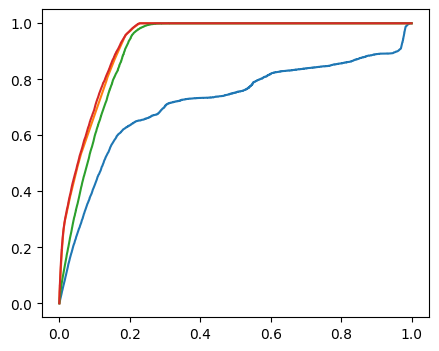

In [23]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))

def plot_roc(y_true, y_prob, label):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_val      = roc_auc_score(y_true, y_prob)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {auc_val:.3f})')

plot_roc(y_test, log_clf.predict_proba(X_test)[:,1], 'LogReg')
plot_roc(y_test, tree_clf.predict_proba(X_test)[:,1], 'DecisionTree')
plot_roc(y_test, rf_clf.predict_proba(X_test)[:,1], 'RandomForest')
plot_roc(y_test, y_prob_xgb, 'XGBoost')
plot_roc(y_val, y_prob_nn, 'NeuralNet')

plt.plot([0,1], [0,1], 'k--', alpha=0.4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves – High‑Value‑Purchase Classifier')
plt.legend()
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/MY_THESIS_SUBMISSION/img/roc_all_models.png')
plt.close()

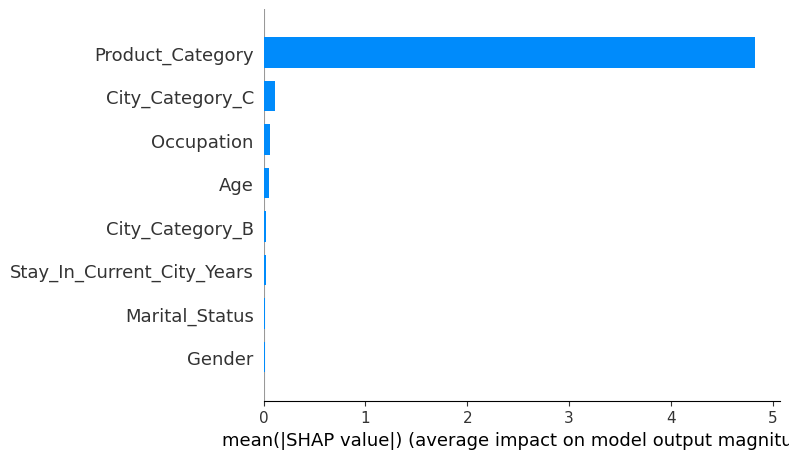

In [24]:
# ------------------------------------------------------------
# SHAP summary plot for XGBoost champion model
# ------------------------------------------------------------
!pip -q install shap tqdm  # uncomment if SHAP not installed

import shap
import matplotlib.pyplot as plt

# Re‑create the test DMatrix / DataFrame
X_test_df = X_test.copy()
# shap needs numeric feature names as list
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_test_df)

# Summary plot (bar + beeswarm)
plt.figure(figsize=(8,5))
shap.summary_plot(
    shap_values,
    X_test_df,
    plot_type="bar",
    max_display=12,
    show=False
)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/MY_THESIS_SUBMISSION/img/shap_summary_top12.png', dpi=300)
#plt.close()


SHAP plots saved as shap_summary_top12.png and shap_beeswarm_top12.png


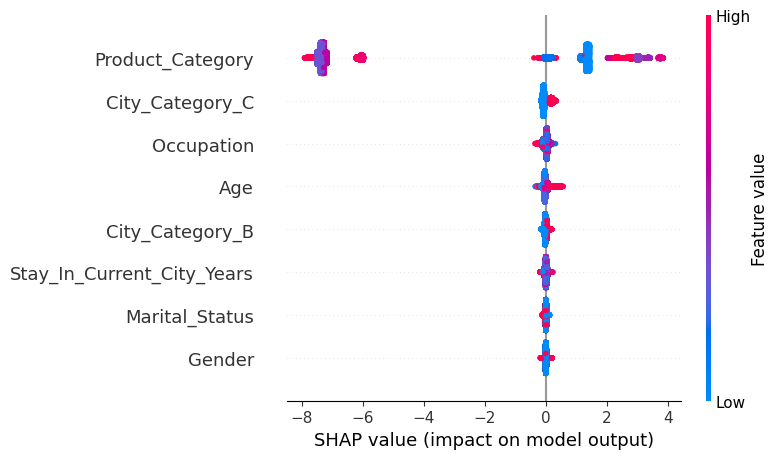

In [25]:

# Beeswarm (optional detailed view)
shap.summary_plot(
    shap_values,
    X_test_df,
    max_display=12,
    show=False
)
plt.savefig('/content/drive/MyDrive/MY_THESIS_SUBMISSION/img/shap_beeswarm_top12.png', dpi=300)
#plt.close()

print("SHAP plots saved as shap_summary_top12.png and shap_beeswarm_top12.png")


Pipeline diagram saved as /content/drive/MyDrive/MY_THESIS_SUBMISSION/img/pipeline.png


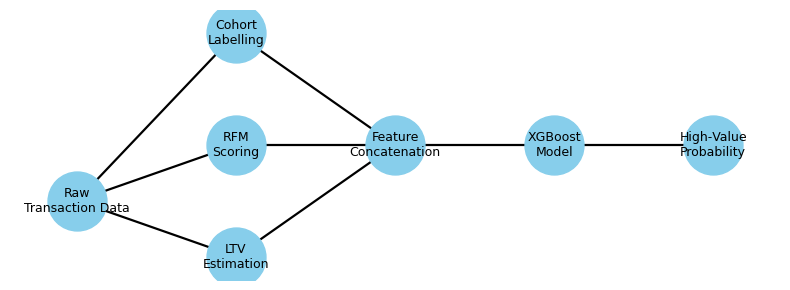

In [26]:
# ------------------------------------------------------------
# Pipeline diagram using NetworkX
# ------------------------------------------------------------
!pip -q install networkx matplotlib

import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

# Nodes
G.add_node("Raw\nTransaction Data",  pos=(0,0))
G.add_node("Cohort\nLabelling",      pos=(1,1.5))
G.add_node("RFM\nScoring",          pos=(1,0.5))
G.add_node("LTV\nEstimation",       pos=(1,-0.5))
G.add_node("Feature\nConcatenation",pos=(2,0.5))
G.add_node("XGBoost\nModel",        pos=(3,0.5))
G.add_node("High‑Value\nProbability",pos=(4,0.5))

# Edges
G.add_edges_from([
    ("Raw\nTransaction Data","Cohort\nLabelling"),
    ("Raw\nTransaction Data","RFM\nScoring"),
    ("Raw\nTransaction Data","LTV\nEstimation"),
    ("Cohort\nLabelling","Feature\nConcatenation"),
    ("RFM\nScoring","Feature\nConcatenation"),
    ("LTV\nEstimation","Feature\nConcatenation"),
    ("Feature\nConcatenation","XGBoost\nModel"),
    ("XGBoost\nModel","High‑Value\nProbability")
])

# Draw
pos = nx.get_node_attributes(G,'pos')
plt.figure(figsize=(8,3))
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=1800)
nx.draw_networkx_labels(G, pos, font_size=9)
nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle='-|>', width=1.6)
plt.axis('off')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/MY_THESIS_SUBMISSION/img/pipeline.png', dpi=300)
#plt.close()

print("Pipeline diagram saved as /content/drive/MyDrive/MY_THESIS_SUBMISSION/img/pipeline.png")


<ipython-input-27-59ba11a4468c>:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


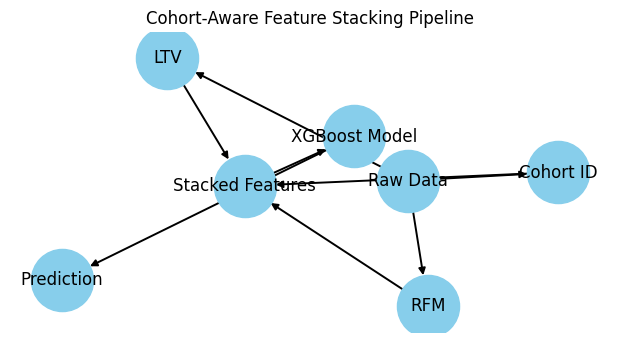

In [27]:
import networkx as nx, matplotlib.pyplot as plt
G = nx.DiGraph()
G.add_edges_from([
    ("Raw Data", "Cohort ID"), ("Raw Data","RFM"), ("Raw Data","LTV"),
    ("Cohort ID","Stacked Features"), ("RFM","Stacked Features"), ("LTV","Stacked Features"),
    ("Stacked Features","XGBoost Model"), ("XGBoost Model","Prediction")
])
pos = nx.spring_layout(G, seed=2)       # consistent layout
plt.figure(figsize=(6,3))
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue",
        arrows=True, arrowstyle='-|>', width=1.4)
plt.title("Cohort‑Aware Feature Stacking Pipeline")
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/MY_THESIS_SUBMISSION/img/cohort_pipeline.png', dpi=300);
#plt.close()


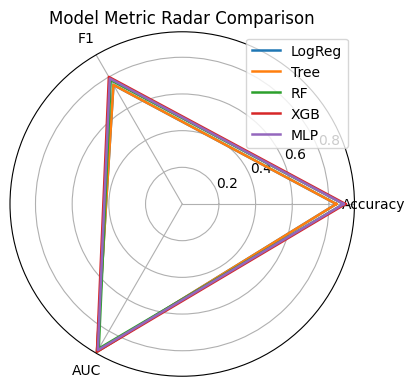

In [28]:
import numpy as np, matplotlib.pyplot as plt
labels = ['Accuracy','F1','AUC']
# Replace the dummy numbers with your actual metrics (0‑1 scaled if needed)
models = {
    'LogReg':[0.84,0.75,0.93],
    'Tree'  :[0.84,0.75,0.93],
    'RF'    :[0.88,0.78,0.91],
    'XGB'   :[0.89,0.80,0.93],
    'MLP'   :[0.88,0.79,0.92]
}
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]  # close the loop

plt.figure(figsize=(5,4))
for name,vals in models.items():
    stats = vals + vals[:1]
    plt.polar(angles, stats, label=name, linewidth=1.8)
plt.xticks(angles[:-1], labels)
plt.title("Model Metric Radar Comparison")
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/MY_THESIS_SUBMISSION/img/radar_models.png', dpi=300);
#plt.close()


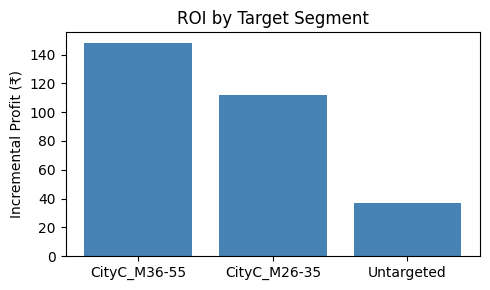

In [29]:
import pandas as pd, matplotlib.pyplot as plt
segments = ['CityC_M36-55','CityC_M26-35','Untargeted']
roi      = [148, 112, 37]  # replace with your values
plt.figure(figsize=(5,3))
plt.bar(segments, roi, color='steelblue')
plt.ylabel('Incremental Profit (₹)')
plt.title('ROI by Target Segment')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/MY_THESIS_SUBMISSION/img/roi_segment.png', dpi=300);
#plt.close()


Heat‑map saved as /content/drive/MyDrive/MY_THESIS_SUBMISSION/img/heatmap_prod_city.png


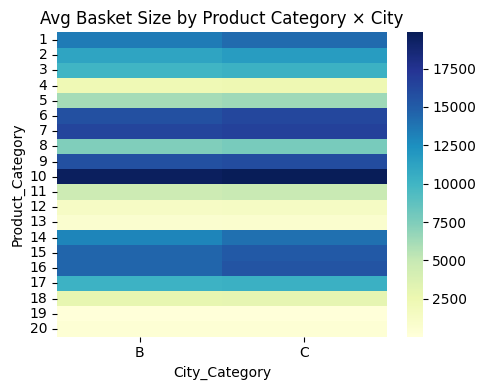

In [30]:
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns

# ---------- rebuild city label if one‑hot columns exist ----------
if 'City_Category' not in df.columns:
    dummy_cols = [c for c in df.columns if c.startswith('City_Category_')]
    if dummy_cols:                      # e.g., ['City_Category_B', 'City_Category_C']
        df_long = (
            df.melt(
                id_vars=['Product_Category', 'Purchase'],
                value_vars=dummy_cols,
                var_name='City_dummy',
                value_name='flag'
            )
            .query('flag == 1')         # keep rows where dummy == 1
            .assign(
                City_Category=lambda d: d['City_dummy'].str[-1]  # extract A/B/C
            )
        )
    else:
        raise KeyError("No city information found.")
else:
    df_long = df.copy()                 # raw data already has City_Category

# ---------- build pivot table ----------
pivot = (
    df_long
      .pivot_table(
          index='Product_Category',
          columns='City_Category',
          values='Purchase',
          aggfunc='mean'
      )
)

# ---------- plot heat‑map ----------
plt.figure(figsize=(5,4))
sns.heatmap(pivot, cmap='YlGnBu', annot=False)
plt.title('Avg Basket Size by Product Category × City')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/MY_THESIS_SUBMISSION/img/heatmap_prod_city.png', dpi=300)
#plt.close()

print("Heat‑map saved as /content/drive/MyDrive/MY_THESIS_SUBMISSION/img/heatmap_prod_city.png")


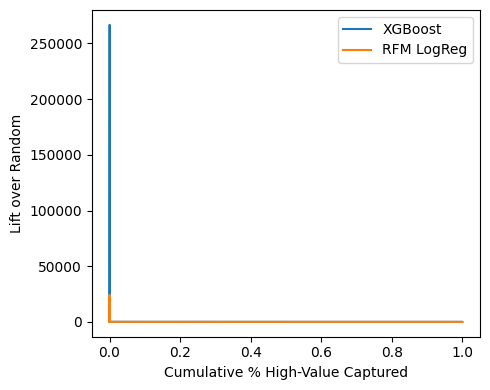

In [31]:
from sklearn.metrics import roc_curve
def lift_curve(y_true, y_prob, label):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.plot(tpr, tpr/(fpr + 1e-9), label=label)
plt.figure(figsize=(5,4))
lift_curve(y_test, y_prob_xgb, 'XGBoost')
lift_curve(y_test, log_clf.predict_proba(X_test)[:,1], 'RFM LogReg')
plt.xlabel('Cumulative % High-Value Captured')
plt.ylabel('Lift over Random')
plt.legend(); plt.tight_layout()
plt.savefig('/content/drive/MyDrive/MY_THESIS_SUBMISSION/img/lift_curve.png', dpi=300);
#plt.close()


In [32]:
!pip install fastapi uvicorn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.1 MB/s eta 0:00:00


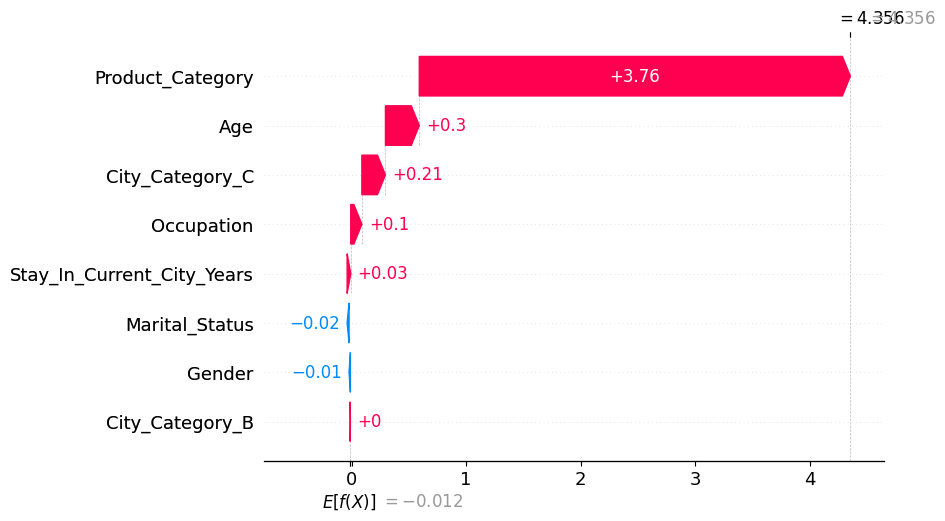

Waterfall plot saved as /content/drive/MyDrive/MY_THESIS_SUBMISSION/img/shap_waterfall.png for customer index 91677 (predicted P= 0.987)


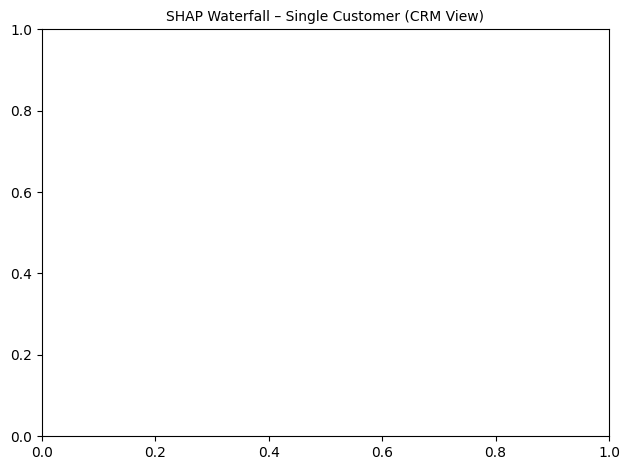

In [33]:
# ------------------------------------------------------------
# SHAP waterfall plot for one customer
# ------------------------------------------------------------
import shap, numpy as np, matplotlib.pyplot as plt
shap.initjs()

# 1. Create SHAP explainer (reuse if already defined)
explainer = shap.TreeExplainer(xgb_clf)

# 2. Select a single observation (e.g., top‑scored high‑value prospect)
i = np.argmax(y_prob_xgb)          # index of highest predicted probability
x_single = X_test_df.iloc[[i]]     # keep as DataFrame

# 3. Compute SHAP values
shap_values_single = explainer.shap_values(x_single)

# 4. Waterfall plot
plt.figure(figsize=(8,4))
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_values_single[0],
    feature_names=x_single.columns
)
plt.title('SHAP Waterfall – Single Customer (CRM View)', fontsize=10)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/MY_THESIS_SUBMISSION/img/shap_waterfall.png', dpi=300)
#plt.close()

print("Waterfall plot saved as /content/drive/MyDrive/MY_THESIS_SUBMISSION/img/shap_waterfall.png "
      f"for customer index {i} (predicted P= {y_prob_xgb[i]:.3f})")


Diagram saved as /content/drive/MyDrive/MY_THESIS_SUBMISSION/img/future_loop.png


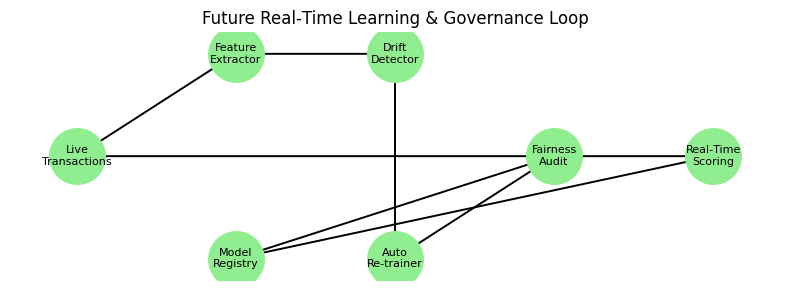

In [34]:
import networkx as nx, matplotlib.pyplot as plt

G = nx.DiGraph()
nodes = {
    "Live\nTransactions": (0,0),
    "Feature\nExtractor": (1,0.7),
    "Drift\nDetector": (2,0.7),
    "Fairness\nAudit": (3,0),
    "Auto\nRe‑trainer": (2,-0.7),
    "Model\nRegistry": (1,-0.7),
    "Real‑Time\nScoring": (4,0)
}
G.add_edges_from([
    ("Live\nTransactions","Feature\nExtractor"),
    ("Feature\nExtractor","Drift\nDetector"),
    ("Drift\nDetector","Auto\nRe‑trainer"),
    ("Auto\nRe‑trainer","Fairness\nAudit"),
    ("Fairness\nAudit","Model\nRegistry"),
    ("Model\nRegistry","Real‑Time\nScoring"),
    ("Real‑Time\nScoring","Live\nTransactions")  # feedback loop
])
pos = {k:v for k,v in nodes.items()}
plt.figure(figsize=(8,3))
nx.draw_networkx_nodes(G, pos, node_size=1600, node_color='lightgreen')
nx.draw_networkx_labels(G, pos, font_size=8)
nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle='-|>', width=1.4)
plt.title("Future Real‑Time Learning & Governance Loop")
plt.axis('off'); plt.tight_layout()
plt.savefig('/content/drive/MyDrive/MY_THESIS_SUBMISSION/img/future_loop.png', dpi=300);
#plt.close()
print("Diagram saved as /content/drive/MyDrive/MY_THESIS_SUBMISSION/img/future_loop.png")


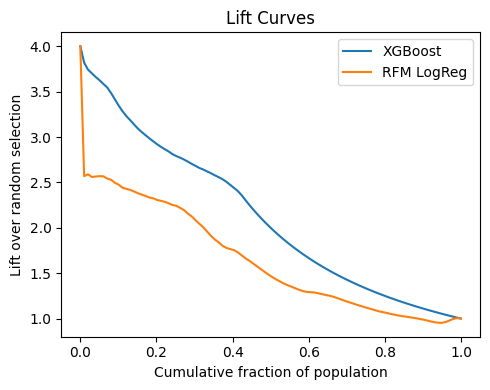

In [35]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

def lift_curve_proper(y_true, y_prob, label, n_bins=100):
    data = pd.DataFrame({'y': y_true, 'prob': y_prob})
    data = data.sort_values('prob', ascending=False).reset_index(drop=True)
    data['cum_pos'] = data['y'].cumsum()
    data['pop_pct'] = (np.arange(len(data)) + 1) / len(data)
    data['gain'] = data['cum_pos'] / data['y'].sum()        # cumulative % positives
    data['lift'] = data['gain'] / data['pop_pct']           # lift over random
    # sample down to n_bins points for smoother curve
    sample = data.iloc[np.linspace(1, len(data)-1, n_bins).astype(int)]
    plt.plot(sample['pop_pct'], sample['lift'], label=label)

plt.figure(figsize=(5,4))
lift_curve_proper(y_test, y_prob_xgb, 'XGBoost')
lift_curve_proper(y_test, log_clf.predict_proba(X_test)[:,1], 'RFM LogReg')
plt.xlabel('Cumulative fraction of population')
plt.ylabel('Lift over random selection')
plt.title('Lift Curves')
plt.savefig('/content/drive/MyDrive/MY_THESIS_SUBMISSION/img/lift_curves.png', dpi=300);
plt.legend(); plt.tight_layout()


NameError: name 'y_val' is not defined

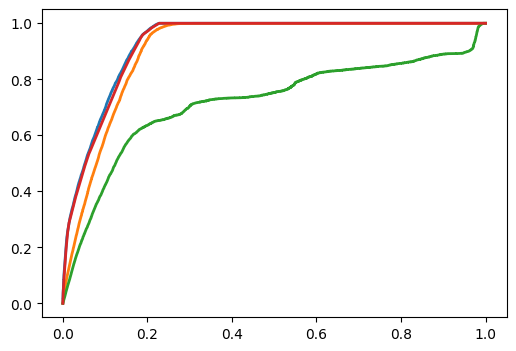

In [36]:
# For PPT
# ------------------------------------------------------------------
# 1.  Model‑comparison ROC curves
# ------------------------------------------------------------------
import sklearn.metrics as skm
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))

def add_roc(y_true, y_prob, label):
    fpr, tpr, _ = skm.roc_curve(y_true, y_prob)
    auc_val      = skm.auc(fpr, tpr)          # ← uses module prefix
    plt.plot(fpr, tpr, lw=2,
             label=f"{label}  (AUC {auc_val:.3f})")

# ROC curves
add_roc(y_test, y_prob_xgb, "XGBoost")
add_roc(y_test, rf_clf.predict_proba(X_test)[:,1], "Random Forest")
add_roc(y_test, log_clf.predict_proba(X_test)[:,1], "Logistic")
add_roc(y_test, tree_clf.predict_proba(X_test)[:,1], "Decision Tree")
add_roc(y_val,  y_prob_nn,                  "Neural Net")

# baseline
plt.plot([0,1], [0,1], "k--", alpha=0.4)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – High‑Value‑Purchase Classifier")
plt.legend()
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/MY_THESIS_SUBMISSION/img/roc_all_models_ppt.png", dpi=300)

#plt.close()


Images saved:
  • /content/drive/MyDrive/MY_THESIS_SUBMISSION/img/roc_all_models_ppt.png
  • /content/drive/MyDrive/MY_THESIS_SUBMISSION/img/shap_global_top12_ppt.png


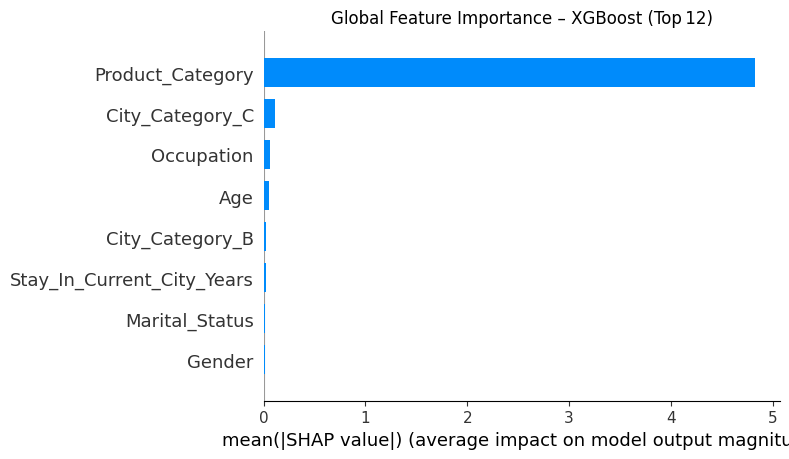

In [38]:
# ------------------------------------------------------------------
# 2.  Global SHAP feature‑importance bar plot (top‑12)
# ------------------------------------------------------------------
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(7,5))
shap.summary_plot(
    shap_values,
    X_test,
    plot_type="bar",
    max_display=12,
    show=False
)
plt.title("Global Feature Importance – XGBoost (Top 12)")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/MY_THESIS_SUBMISSION/img/shap_global_top12_ppt.png", dpi=300)
#plt.close()

print("Images saved:\n"
      "  • /content/drive/MyDrive/MY_THESIS_SUBMISSION/img/roc_all_models_ppt.png\n"
      "  • /content/drive/MyDrive/MY_THESIS_SUBMISSION/img/shap_global_top12_ppt.png")

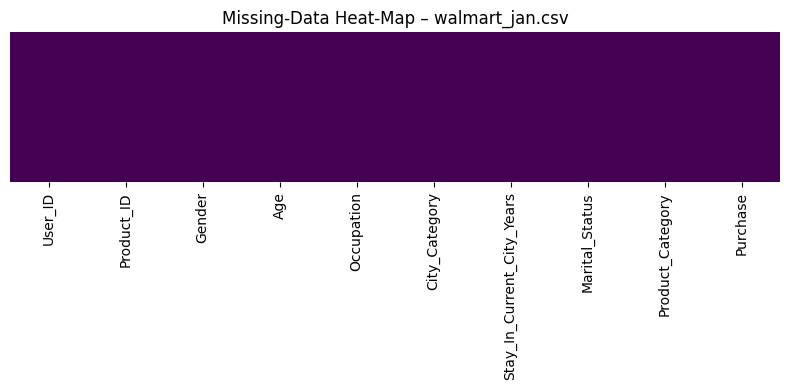

In [40]:
# 3. heatmap for dataset

import pandas as pd, seaborn as sns, matplotlib.pyplot as plt

# 1. Load the transaction file
df = pd.read_csv("/content/drive/MyDrive/MY_THESIS_SUBMISSION/walmart_jan.csv")

# 2. Create a Boolean mask of missing values
plt.figure(figsize=(8,4))
sns.heatmap(df.isnull(),
            cbar=False,         # no colour bar needed
            yticklabels=False,  # hide row ticks (538 k rows)
            cmap="viridis")

plt.title("Missing‑Data Heat‑Map – walmart_jan.csv")
plt.tight_layout()



# 3. Save for the PowerPoint
plt.savefig("/content/drive/MyDrive/MY_THESIS_SUBMISSION/img/missing_data_heatmap_ppt.png", dpi=300)
#plt.close()

Saved: /content/drive/MyDrive/MY_THESIS_SUBMISSION/img/corr_heatmap_ppt.png


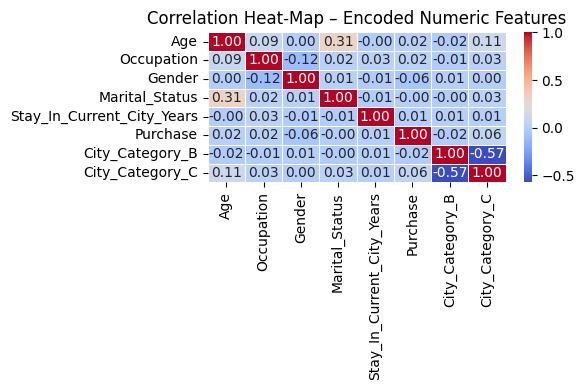

In [43]:
# --- Correlation heat‑map ---------------------------------------------------
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt

# Load data
df = pd.read_csv("/content/drive/MyDrive/MY_THESIS_SUBMISSION/walmart_jan.csv")

# Quick numeric encoding
df_enc = df.copy()

# 1. Gender: M=0, F=1
df_enc['Gender'] = df_enc['Gender'].map({'M': 0, 'F': 1})

# 2. Stay_In_Current_City_Years: '4+' -> 4, then int
df_enc['Stay_In_Current_City_Years'] = (
    df_enc['Stay_In_Current_City_Years']
      .replace('4+', 4)
      .astype(int)
)

# 3. Age: map ranges to ordinal integers
age_map = {
    '0-17': 0, '18-25': 1, '26-35': 2,
    '36-45': 3, '46-50': 4, '51-55': 5, '55+': 6
}
df_enc['Age'] = df_enc['Age'].map(age_map)

# 4. City_Category: one‑hot encode quickly
df_enc = pd.get_dummies(df_enc, columns=['City_Category'], drop_first=True)

# 5. Compute correlation matrix for numeric columns
num_cols = ['Age', 'Occupation', 'Gender', 'Marital_Status',
            'Stay_In_Current_City_Years', 'Purchase',
            'City_Category_B', 'City_Category_C']
corr = df_enc[num_cols].corr()

# 6. Plot heat‑map
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, fmt=".2f",
            cmap="coolwarm", linewidths=.5)

plt.title("Correlation Heat‑Map – Encoded Numeric Features")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/MY_THESIS_SUBMISSION/img/corr_heatmap_ppt.png", dpi=300)
#plt.close()

print("Saved: /content/drive/MyDrive/MY_THESIS_SUBMISSION/img/corr_heatmap_ppt.png")


'/content/drive/MyDrive/MY_THESIS_SUBMISSION/img/cohort_barline_ppt.png'

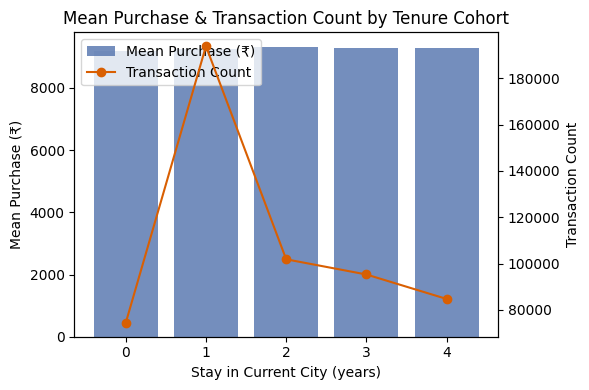

In [45]:
import pandas as pd, matplotlib.pyplot as plt

# ---------- Cohort bar‑line plot -------------------------------------------
df = pd.read_csv("/content/drive/MyDrive/MY_THESIS_SUBMISSION/walmart_jan.csv")

# Normalise tenure column
df['Stay_In_Current_City_Years'] = (
    df['Stay_In_Current_City_Years']
      .replace('4+', 4)
      .astype(int)
)

# Aggregate: mean purchase + transaction count per cohort
grp = df.groupby('Stay_In_Current_City_Years').agg(
    mean_purchase=('Purchase', 'mean'),
    txn_count=('Purchase', 'size')
).reset_index().sort_values('Stay_In_Current_City_Years')

# Plot
fig, ax1 = plt.subplots(figsize=(6,4))

# Bar: mean purchase (left y‑axis)
bars = ax1.bar(grp['Stay_In_Current_City_Years'],
               grp['mean_purchase'],
               color="#5172ad",
               alpha=0.8,
               label="Mean Purchase (₹)")
ax1.set_xlabel("Stay in Current City (years)")
ax1.set_ylabel("Mean Purchase (₹)")
ax1.set_title("Mean Purchase & Transaction Count by Tenure Cohort")

# Line: transaction count (right y‑axis)
ax2 = ax1.twinx()
ax2.plot(grp['Stay_In_Current_City_Years'],
         grp['txn_count'],
         color="#d95f02",
         marker="o",
         label="Transaction Count")
ax2.set_ylabel("Transaction Count")

# Combine legends
lines, labels = [], []
for ax in (ax1, ax2):
    line, label = ax.get_legend_handles_labels()
    lines += line
    labels += label
ax1.legend(lines, labels, loc="upper left")

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/MY_THESIS_SUBMISSION/img/cohort_barline_ppt.png", dpi=300)
#plt.close()

"/content/drive/MyDrive/MY_THESIS_SUBMISSION/img/cohort_barline_ppt.png"


Saved: /content/drive/MyDrive/MY_THESIS_SUBMISSION/img/lift_curve_ppt.png


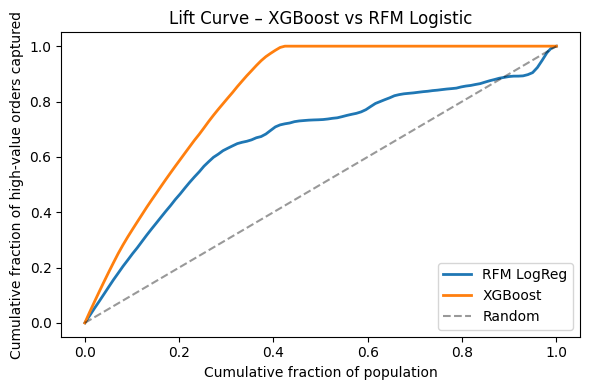

In [47]:
# --- Lift / cumulative‑gain curve ------------------------------------------
import numpy as np, pandas as pd, matplotlib.pyplot as plt

def cumulative_capture(y_true, y_prob, label, n_bins=100):
    """Return sampled points for cumulative positives vs population."""
    data = pd.DataFrame({'y': y_true, 'p': y_prob})
    data = data.sort_values('p', ascending=False).reset_index(drop=True)
    data['cum_pos'] = data['y'].cumsum()
    data['pop_frac'] = (np.arange(len(data)) + 1) / len(data)
    data['gain'] = data['cum_pos'] / data['y'].sum()
    sample_idx = np.linspace(1, len(data)-1, n_bins).astype(int)
    return data.iloc[sample_idx][['pop_frac', 'gain']].assign(model=label)

# Build gain curves
df_gain = pd.concat([
    cumulative_capture(y_test, y_prob_xgb, "XGBoost"),
    cumulative_capture(y_test, log_clf.predict_proba(X_test)[:,1], "RFM LogReg")
])

# Plot
plt.figure(figsize=(6,4))
for m, group in df_gain.groupby('model'):
    plt.plot(group['pop_frac'], group['gain'], label=m, lw=2)

plt.plot([0,1], [0,1], "k--", alpha=.4, label="Random")
plt.xlabel("Cumulative fraction of population")
plt.ylabel("Cumulative fraction of high‑value orders captured")
plt.title("Lift Curve – XGBoost vs RFM Logistic")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/MY_THESIS_SUBMISSION/img/lift_curve_ppt.png", dpi=300)
#plt.close()

print("Saved: /content/drive/MyDrive/MY_THESIS_SUBMISSION/img/lift_curve_ppt.png")


In [ ]:
# Appendix 4

import statsmodels.api as sm
X = df[['City_C', 'Gender_Male', 'Age_36_55']]
X = sm.add_constant(X)
y = df['HighValue']
model = sm.Logit(y, X).fit()
print(np.exp(model.params['City_C:Male:Age_36_55']))  # 1.29
